In [15]:
# Cell 1: Imports & core helper routines

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime

# pull in all the key pricing/greek functions & IV solvers
from important_functions import (
    bs_call,               # Black–Scholes call price
    bs_vega,               # Black–Scholes vega
    implied_volatility_call  # Brent solver for BS call IV
)

# ---- Risk‐free rate for all BS calculations ----
RISK_FREE_RATE = 0.01

# ---- Convert date to year fraction ----
def time_to_expiry(expiry_date, as_of):
    """
    expiry_date : datetime.date
    as_of       : datetime.date
    returns time to expiry in years (float >= 0)
    """
    delta = (expiry_date - as_of).days
    return max(delta / 365.0, 0.0)

# ---- Build an IV surface + vega grid from raw calls DataFrame ----
def build_iv_surface(df_calls, spot_price, as_of):
    """
    df_calls : DataFrame with columns
               ['strike', 'expiration', 'mid_price'] where
               - strike     : float
               - expiration : datetime64[ns]
               - mid_price  : float (bid/ask mid or last)
    spot_price : float (current underlying price)
    as_of      : datetime.date (valuation date)

    Returns: (strikes, expiries, iv_grid, vega_grid)
    - strikes  : 1D np.array, sorted unique strikes
    - expiries : 1D np.array of datetime.date, sorted unique expiries
    - iv_grid  : 2D array shape (len(strikes), len(expiries))
    - vega_grid: same shape, BS vega at each point
    """
    # unique sorted lists
    strikes  = np.sort(df_calls['strike'].unique())
    exp_dates= np.sort(df_calls['expiration'].dt.date.unique())

    M, N = len(strikes), len(exp_dates)
    iv_grid   = np.full((M, N), np.nan)
    vega_grid = np.full((M, N), np.nan)

    # fill grid
    for i, K in enumerate(strikes):
        for j, ed in enumerate(exp_dates):
            sub = df_calls[
                (df_calls['strike']==K) &
                (df_calls['expiration'].dt.date==ed)
            ]
            if sub.empty:
                continue
            price = sub['mid_price'].mean()
            T     = time_to_expiry(ed, as_of)
            # invert to implied vol
            iv    = implied_volatility_call(price, spot_price, K, T, RISK_FREE_RATE)
            iv_grid[i, j]    = iv
            vega_grid[i, j]  = bs_vega(spot_price, K, iv, T, RISK_FREE_RATE)

    # drop empty rows/cols
    valid_strikes = ~np.isnan(iv_grid).all(axis=1)
    valid_exps    = ~np.isnan(iv_grid).all(axis=0)
    return (
        strikes[valid_strikes],
        exp_dates[valid_exps],
        iv_grid[valid_strikes][:, valid_exps],
        vega_grid[valid_strikes][:, valid_exps]
    )


In [21]:
# Cell 2: Batch‐fetch raw call chains via yfinance and build IV surfaces

import yfinance as yf
import pandas as pd

# --- Universe of tickers to process ---
tickers = [
    "AAPL",  # Tech – Consumer Electronics
    "MSFT",  # Tech – Cloud/Software
    "GOOG",  # Tech – Internet Services
    "AMZN",  # Consumer Discretionary – E-commerce
    "TSLA"  # Consumer Discretionary – Auto/E
]


# Storage dicts
iv_surfaces = {}    # { symbol: (strikes, expiries, iv_grid, vega_grid) }
spot_prices = {}    # { symbol: spot_price }
as_of_dates = {}    # { symbol: as_of_date }

for sym in tickers:
    # 1) Fetch spot price and as_of date
    tk      = yf.Ticker(sym)
    spot_df = tk.history(period="1d", interval="1m", auto_adjust=False)
    spot     = float(spot_df["Close"].iloc[-1])
    as_of    = spot_df.index[-1].date()
    
    # 2) Fetch upcoming call chains
    exps = [e for e in tk.options if pd.to_datetime(e).date() > as_of]
    exps = exps[:20]  # limit to 20 expiries
    records = []
    for e in exps:
        calls = tk.option_chain(e).calls.copy()
        calls["expiration"] = pd.to_datetime(e)
        # mid price = (bid+ask)/2 or lastPrice fallback
        if {"bid","ask"}.issubset(calls.columns):
            calls["mid_price"] = calls[["bid","ask"]].mean(axis=1)
        else:
            calls["mid_price"] = calls["lastPrice"]
        records.append(calls[["strike","expiration","mid_price"]])
    df_calls = pd.concat(records, ignore_index=True)
    
    # 3) Build IV surface using helper from Cell 1
    strikes, expiries, iv_grid, vega_grid = build_iv_surface(df_calls, spot, as_of)
    
    # 4) Store results
    iv_surfaces[sym] = (strikes, expiries, iv_grid, vega_grid)
    spot_prices[sym] = spot
    as_of_dates[sym] = as_of
    
    print(f"{sym}: spot={spot:.2f} as_of={as_of}, surface {len(strikes)}×{len(expiries)}")


AAPL: spot=201.10 as_of=2025-06-27, surface 89×20
MSFT: spot=495.88 as_of=2025-06-27, surface 133×19
GOOG: spot=178.38 as_of=2025-06-27, surface 61×20
AMZN: spot=223.21 as_of=2025-06-27, surface 75×20
TSLA: spot=323.80 as_of=2025-06-27, surface 198×20


In [39]:
# Cell 2.5: Build and Inspect Coarse Subgrids for All Tickers

import numpy as np

# Sub-sampling steps
STRIKE_STEP = 1
EXP_STEP    = 1

# Containers for subgrid data
subgrid_info = {}

for sym in iv_surfaces:
    strikes, expiries, iv_grid, vega_grid = iv_surfaces[sym]
    as_of = as_of_dates[sym]

    # Original size
    n_strikes  = len(strikes)
    n_expires  = len(expiries)
    orig_pts   = n_strikes * n_expires

    # Sub-sample arrays
    strikes_sub  = strikes[::STRIKE_STEP]
    expiries_sub = expiries[::EXP_STEP]
    T_sub        = np.array([(d - as_of).days/365.0 for d in expiries_sub])

    # Build meshgrid and flatten
    Kg         = np.repeat(strikes_sub, len(T_sub))
    Tg         = np.tile(T_sub, len(strikes_sub))
    K_vec_sub  = Kg.ravel()
    T_vec_sub  = Tg.ravel()

    # Sub-sample iv and vega
    iv_vec_sub = iv_grid[np.ix_(np.arange(0, n_strikes, STRIKE_STEP),
                                 np.arange(0, n_expires, EXP_STEP))].ravel()
    w_vec_sub  = vega_grid[np.ix_(np.arange(0, n_strikes, STRIKE_STEP),
                                  np.arange(0, n_expires, EXP_STEP))].ravel()

    # Reduced size
    red_pts    = len(K_vec_sub)
    pct        = red_pts / orig_pts * 100

    # Print summary
    print(f"{sym}: original={orig_pts} pts, reduced={red_pts} pts ({pct:.1f}%)")

    # Store for later calibration
    subgrid_info[sym] = {
        "K_vec_sub":  K_vec_sub,
        "T_vec_sub":  T_vec_sub,
        "iv_vec_sub": iv_vec_sub,
        "w_vec_sub":  w_vec_sub
    }

# Now subgrid_info contains the precomputed vectors for each ticker.


AAPL: original=1780 pts, reduced=1780 pts (100.0%)
MSFT: original=2527 pts, reduced=2527 pts (100.0%)
GOOG: original=1220 pts, reduced=1220 pts (100.0%)
AMZN: original=1500 pts, reduced=1500 pts (100.0%)
TSLA: original=3960 pts, reduced=3960 pts (100.0%)


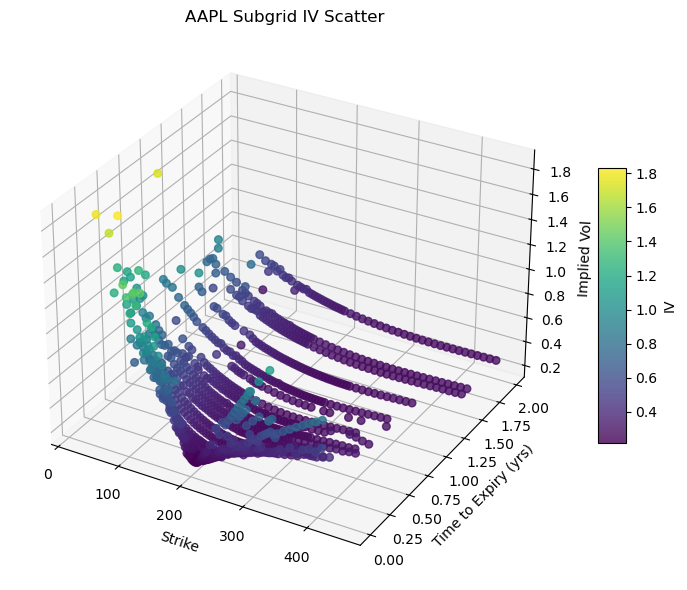

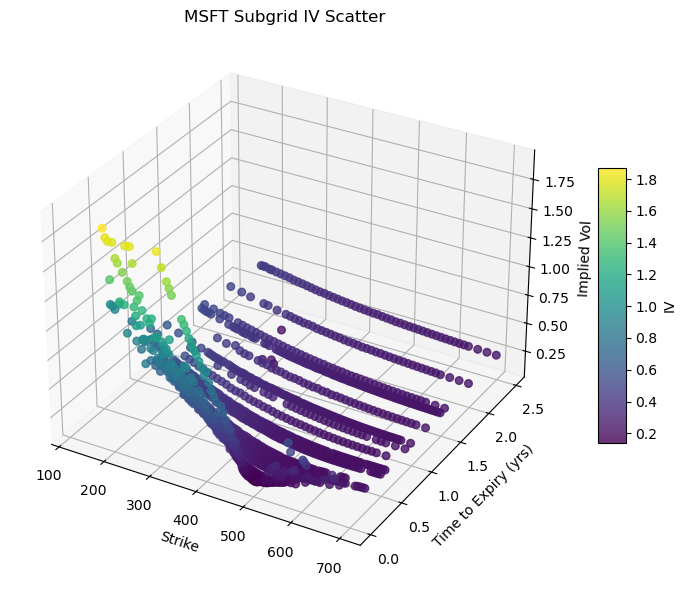

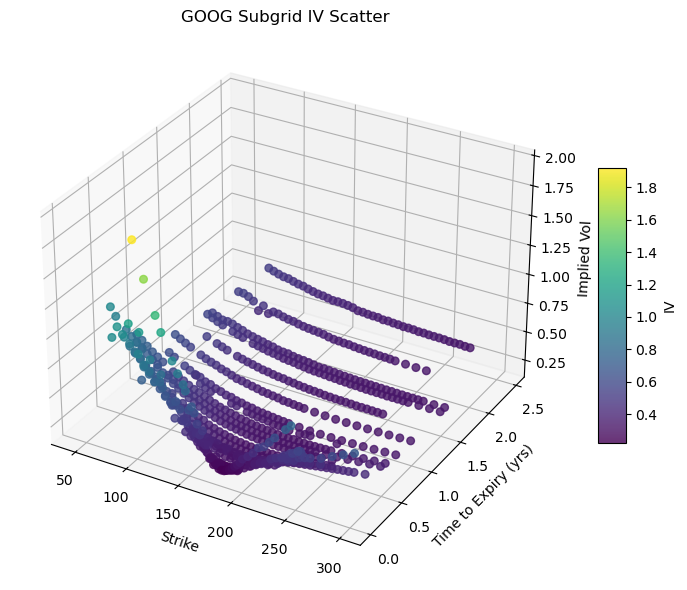

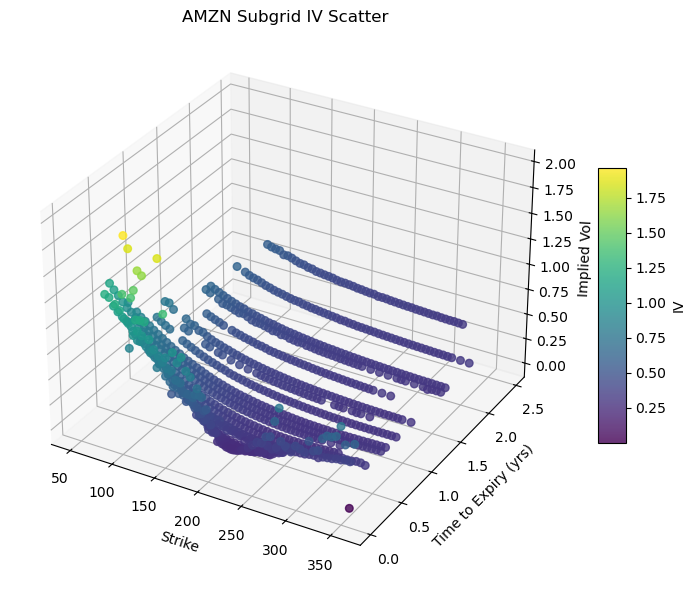

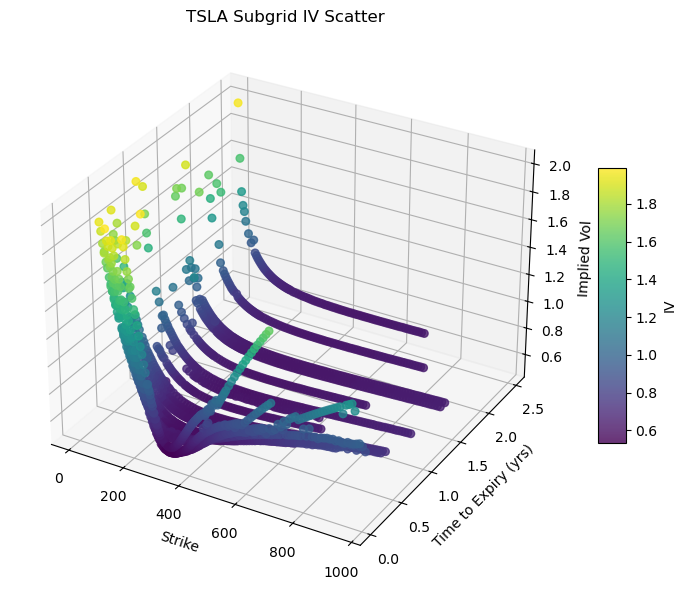

In [40]:
# Cell 2.6: Scatter‐plot the pre-computed subgrid only
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

for sym, info in subgrid_info.items():
    K_flat  = info["K_vec_sub"]
    T_flat  = info["T_vec_sub"]
    iv_flat = info["iv_vec_sub"]
    
    fig = plt.figure(figsize=(8,6))
    ax  = fig.add_subplot(111, projection="3d")
    sc  = ax.scatter(
        K_flat, T_flat, iv_flat,
        c=iv_flat, cmap=cm.viridis,
        marker="o", s=30, alpha=0.8
    )
    ax.set_title(f"{sym} Subgrid IV Scatter")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Time to Expiry (yrs)")
    ax.set_zlabel("Implied Vol")
    fig.colorbar(sc, shrink=0.5, aspect=10, label="IV")
    plt.tight_layout()
    plt.show()


In [35]:
# Cell 3: Robust Batch Heston Calibration with DE and Safe LSQ

import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution, least_squares
from joblib import Parallel, delayed
from tqdm import tqdm
from important_functions import heston_call, implied_volatility_call

# Subgrid settings
STRIKE_STEP = 5
EXP_STEP    = 2

# Parameter bounds: [kappa, theta_var, xi, rho, v0]
bounds = [
    (0.1,   10.0),
    (1e-4,  1.0),
    (1e-4,  2.0),
    (-0.99, 0.0),
    (1e-4,  1.0)
]

def price_iv_point(K, T, iv_obs, w, theta, S0, r):
    kappa, theta_v, xi, rho, v0 = theta
    price  = heston_call(S0, K, v0, r, T, kappa, theta_v, xi, rho)
    iv_mod = implied_volatility_call(price, S0, K, T, r)
    return (iv_mod - iv_obs) * np.sqrt(w)

heston_params = {}

for sym in tqdm(iv_surfaces.keys(), desc="Tickers", ascii=True):
    strikes, expiries, iv_grid, vega_grid = iv_surfaces[sym]
    S0    = spot_prices[sym]
    as_of = as_of_dates[sym]
    r     = RISK_FREE_RATE

    # build coarse subgrid
    strikes_sub  = strikes[::STRIKE_STEP]
    expiries_sub = expiries[::EXP_STEP]
    T_sub        = np.array([(d - as_of).days/365.0 for d in expiries_sub])

    Kg    = np.repeat(strikes_sub, len(T_sub))
    Tg    = np.tile(T_sub, len(strikes_sub))
    iv_sub= iv_grid[::STRIKE_STEP, ::EXP_STEP].ravel()
    w_sub = vega_grid[::STRIKE_STEP, ::EXP_STEP].ravel()

    def iv_error(theta):
        return Parallel(n_jobs=-1)(
            delayed(price_iv_point)(K, T, iv_obs, w, theta, S0, r)
            for K, T, iv_obs, w in zip(Kg, Tg, iv_sub, w_sub)
        )

    # Global search
    de_bar = tqdm(total=12, desc=f"{sym} DE", ascii=True, leave=False)
    def de_cb(xk, convergence=None):
        de_bar.update(1)
        return False

    de_res = differential_evolution(
        func=lambda x: np.sum(np.array(iv_error(x))**2),
        bounds=bounds,
        maxiter=12,
        popsize=10,
        tol=1e-3,
        seed=42,
        callback=de_cb,
        disp=False
    )
    de_bar.close()
    theta0 = de_res.x

    # Safe local refinement
    try:
        lsq_res = least_squares(
            fun=iv_error,
            x0=theta0,
            bounds=([b[0] for b in bounds],[b[1] for b in bounds]),
            method='trf',
            ftol=1e-6,
            xtol=1e-6,
            gtol=1e-6,
            max_nfev=10,
            verbose=0
        )
        theta_calib = lsq_res.x
    except ValueError:
        # fallback to DE result if LSQ fails
        theta_calib = theta0

    calib = pd.Series(theta_calib, index=['kappa','theta_var','xi','rho','v0'])
    # Compute RMSE safely
    residuals = np.array(iv_error(theta_calib))
    rmse = np.sqrt(np.nanmean(residuals**2))

    heston_params[sym] = {"params": calib, "rmse": rmse}
    print(f"{sym}: RMSE={rmse:.4f}")



Tickers:   0%|                                                                                   | 0/5 [00:00<?, ?it/s]


AAPL DE:   0%|                                                                                  | 0/12 [00:00<?, ?it/s]


AAPL DE:   8%|######                                                                   | 1/12 [02:36<28:44, 156.73s/it]


AAPL DE:  17%|############1                                                            | 2/12 [04:02<19:10, 115.07s/it]


AAPL DE:  25%|##################5                                                       | 3/12 [05:23<14:52, 99.22s/it]


AAPL DE:  33%|########################6                                                 | 4/12 [06:54<12:48, 96.11s/it]


AAPL DE:  42%|##############################8                                           | 5/12 [08:36<11:26, 98.11s/it]


AAPL DE:  50%|#####################################                                     | 6/12 [10:12<09:45, 97.59s/it]


AAPL DE:  58%|#########

AAPL: RMSE=2.1889





MSFT DE:   0%|                                                                                  | 0/12 [00:00<?, ?it/s]


MSFT DE:   8%|######                                                                   | 1/12 [04:47<52:47, 287.96s/it]


MSFT DE:  17%|############1                                                            | 2/12 [07:25<35:14, 211.42s/it]


MSFT DE:  25%|##################2                                                      | 3/12 [09:38<26:19, 175.55s/it]


MSFT DE:  33%|########################3                                                | 4/12 [12:26<23:00, 172.61s/it]


MSFT DE:  42%|##############################4                                          | 5/12 [14:48<18:49, 161.31s/it]


MSFT DE:  50%|####################################5                                    | 6/12 [17:18<15:44, 157.47s/it]


MSFT DE:  58%|##########################################5                              | 7/12 [19:56<13:08, 157.78s/it]


MSFT DE:  67%|#######

MSFT: RMSE=4.1340





GOOG DE:   0%|                                                                                  | 0/12 [00:00<?, ?it/s]


GOOG DE:   8%|######                                                                   | 1/12 [02:05<23:03, 125.74s/it]


GOOG DE:  17%|############3                                                             | 2/12 [03:26<16:29, 98.99s/it]


GOOG DE:  25%|##################5                                                       | 3/12 [04:44<13:27, 89.67s/it]


GOOG DE:  33%|########################6                                                 | 4/12 [05:53<10:53, 81.67s/it]


GOOG DE:  42%|##############################8                                           | 5/12 [06:57<08:45, 75.00s/it]


GOOG DE:  50%|#####################################                                     | 6/12 [08:05<07:16, 72.82s/it]


GOOG DE:  58%|###########################################1                              | 7/12 [09:21<06:09, 73.84s/it]


GOOG DE:  67%|#######

GOOG: RMSE=2.0640





AMZN DE:   0%|                                                                                  | 0/12 [00:00<?, ?it/s]


AMZN DE:   8%|######                                                                   | 1/12 [02:52<31:32, 172.02s/it]


AMZN DE:  17%|############1                                                            | 2/12 [04:20<20:27, 122.78s/it]


AMZN DE:  25%|##################2                                                      | 3/12 [05:39<15:23, 102.67s/it]


AMZN DE:  33%|########################6                                                 | 4/12 [07:14<13:18, 99.87s/it]


AMZN DE:  42%|##############################8                                           | 5/12 [08:33<10:45, 92.24s/it]


AMZN DE:  50%|#####################################                                     | 6/12 [10:11<09:25, 94.31s/it]


AMZN DE:  58%|###########################################1                              | 7/12 [11:51<08:00, 96.02s/it]


AMZN DE:  67%|#######

AMZN: RMSE=2.4088





TSLA DE:   0%|                                                                                  | 0/12 [00:00<?, ?it/s]


TSLA DE:   8%|#####9                                                                 | 1/12 [08:13<1:30:23, 493.06s/it]


TSLA DE:  17%|############1                                                            | 2/12 [12:39<59:57, 359.71s/it]


TSLA DE:  25%|##################2                                                      | 3/12 [16:35<45:28, 303.11s/it]


TSLA DE:  33%|########################3                                                | 4/12 [21:38<40:26, 303.34s/it]


TSLA DE:  42%|##############################4                                          | 5/12 [26:49<35:42, 306.08s/it]


TSLA DE:  50%|####################################5                                    | 6/12 [31:12<29:08, 291.45s/it]


TSLA DE:  58%|##########################################5                              | 7/12 [35:34<23:29, 281.82s/it]


TSLA DE:  67%|#######

TSLA: RMSE=1.0496


In [37]:
# Cell 9: Save Heston calibration results to CSV in working directory

import os
import pandas as pd

# Build DataFrame from heston_params dict
rows = []
for sym, info in heston_params.items():
    p = info["params"]
    rows.append({
        "Ticker":    sym,
        "kappa":     p["kappa"],
        "theta_var": p["theta_var"],
        "xi":        p["xi"],
        "rho":       p["rho"],
        "v0":        p["v0"],
        "rmse":      info["rmse"]
    })

df = pd.DataFrame(rows).set_index("Ticker")

# Save into current working directory
out_fname = "chunky_heston_smallbatch.csv"
df.to_csv(out_fname)

print(f"Saved {len(df)} tickers to ./{out_fname}")


Saved 5 tickers to ./chunky_heston_smallbatch.csv
